In [2]:
# Data modules
import osmnx as ox # For OpenStreetMap data and graphs
import pandas as pd # Data management
# Math modules
import networkx as nx # Graph module to calculate some metrics
import numpy as np
# Plot modules
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import os
import random
import shapely
import geopandas as gpd
from shapely.ops import unary_union

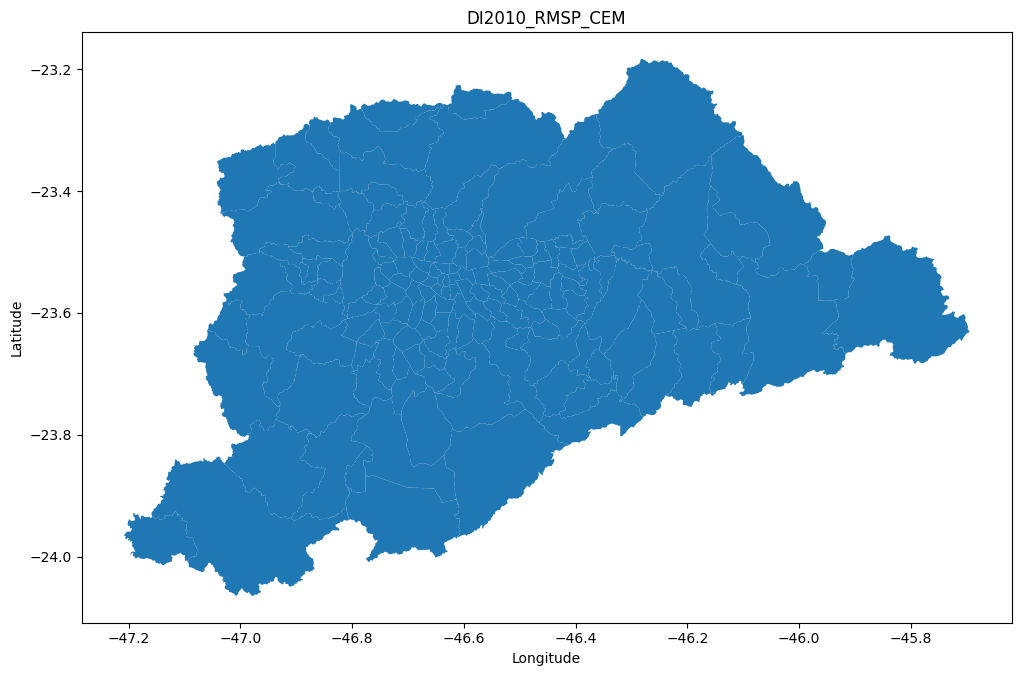

In [3]:
# Read the shapefile
gdf = gpd.read_file('Shapes/DI2010_RMSP_CEM.shp')

# Plot the shapefile
gdf.plot(figsize=(12, 10))
plt.title('DI2010_RMSP_CEM')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

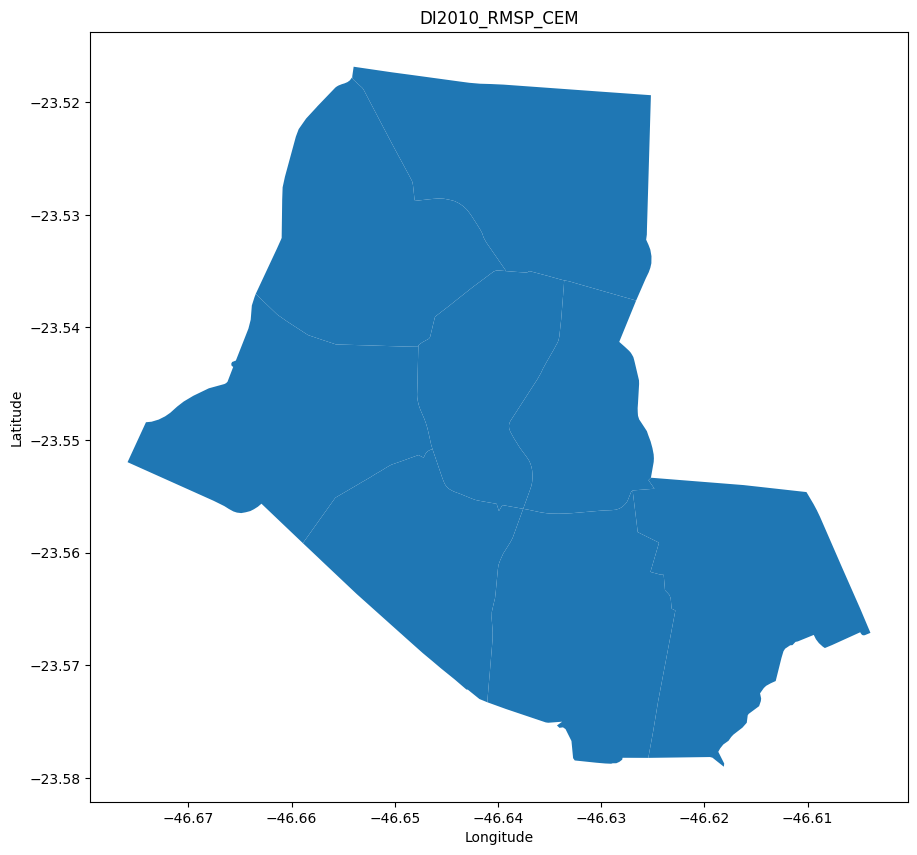

In [4]:
gdf_SP = gdf[gdf["NOM_MU"] == "SAO PAULO"]
# Source: https://drive.prefeitura.sp.gov.br/cidade/secretarias/upload/chamadas/regioes_subprefeituras_e_distritos_municipais_1702504900.htm
Central_regions = ["Bela Vista", "Bom Retiro", "Cambuci", "Consolacao", "Liberdade", "Republica", "Santa Cecilia", "Se"]
gdf_central = gdf_SP[gdf_SP["NOME"].isin([region.upper() for region in Central_regions])]
gdf_central.plot(figsize=(12, 10))
plt.title('DI2010_RMSP_CEM')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [10]:
# Unite all polygons in gdf_central into a single geometry
central_union = gpd.GeoDataFrame(geometry=[unary_union(gdf_central.geometry)], crs=gdf_central.crs).to_crs("epsg:32633").buffer(1000)
central_union = central_union.to_crs(gdf_central.crs)

In [45]:
G_multi = ox.graph_from_polygon(central_union[0], network_type = 'drive') # obtaining the data
G = ox.convert.to_undirected(G) # converting to undirected graph

C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\osmnx\convert.py:542: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])


In [46]:
original_elevation_url = ox.settings.elevation_url_template
ox.settings.elevation_url_template = (
    "https://api.opentopodata.org/v1/aster30m?locations={locations}"
)
G = ox.elevation.add_node_elevations_google(G, batch_size=100, pause=1)
G = ox.elevation.add_edge_grades(G)
ox.settings.elevation_url_template = original_elevation_url


Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0]).copy()

In [51]:
floods = pd.read_csv("https://raw.githubusercontent.com/gioguarnieri/floods_in_sao_paulo/refs/heads/main/floods.csv", header = 0, sep = ';') # getting the flood data from github

l_edges, dists = ox.distance.nearest_edges(G, floods["LONG"], floods["LAT"], return_dist=True) # searching for the nearest edge (street) in the graph to associate the flood
tol = 1e-4 # tolerance of 10m (or 0.0001 degrees) to associate the flood
dict_floods = dict(zip(G.edges, np.zeros(len(G.edges)))) # creating a dict of each street
for i,j in zip(l_edges, dists): # to loop into and see how many floods happened in each street
  if j < tol:
    dict_floods[i] += 1 # adds 1 if the street has appeared in the dataset

nx.set_edge_attributes(G, dict_floods, "flood") # adding the floods into the graph

In [ ]:
H = nx.line_graph(G, nx.Graph)
H.graph['crs'] = G.graph['crs']
H.add_nodes_from((node, G.edges[node]) for node in H)

path = dict(nx.all_pairs_shortest_path_length(H))
msp = {}
for i in path.keys():
  msp[i] = np.array(list(path[i].values())).mean()


nx.set_edge_attributes(G, msp, "Mean Shortest Path Length")
nx.set_edge_attributes(G, nx.closeness_centrality(H), "Closeness")
nx.set_edge_attributes(G, nx.eigenvector_centrality_numpy(H),'Eigenvector')
nx.set_edge_attributes(G, nx.edge_betweenness_centrality(G, weight="length")  , 'bet')
nx.set_edge_attributes(G,dict(H.degree()),'Degree')
nx.set_edge_attributes(G, nx.subgraph_centrality_exp(nx.Graph(H)), "Subgraph Centrality")
nx.set_edge_attributes(G, nx.pagerank(H), "Pagerank")

In [88]:
nodes, edges = ox.graph_to_gdfs(G) # retrieving as dataframes to plot
edges["flood"] = edges["flood"].astype('bool')

edges["highway"] = edges.highway.map(lambda x: x[0] if isinstance(x, list) else x)
edges.reset_index(inplace=True)
edges["lanes"] = edges.lanes.map(lambda x: x[0] if isinstance(x, list) else x)
edges["maxspeed"] = edges.maxspeed.map(lambda x: x[0] if isinstance(x, list) else x)
edges["lanes"] = edges["lanes"].fillna(1)
ii = 0
for i in set(edges.highway):
  edges.replace(i, int(ii), inplace=True)
  ii+=1

nodes.to_csv("nodes_centrals.csv", index = False)
edges.to_csv("edges_centrals.csv", index = False)

C:\Users\gio-x\AppData\Local\Temp\ipykernel_22768\997874868.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  edges.replace(i, int(ii), inplace=True)


C:\Users\gio-x\AppData\Local\Temp\ipykernel_22768\1719963021.py:18: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf_diff.plot(ax=ax, column="NOME", color='black', edgecolor='black', alpha=0.7, legend = True) # plotting the difference


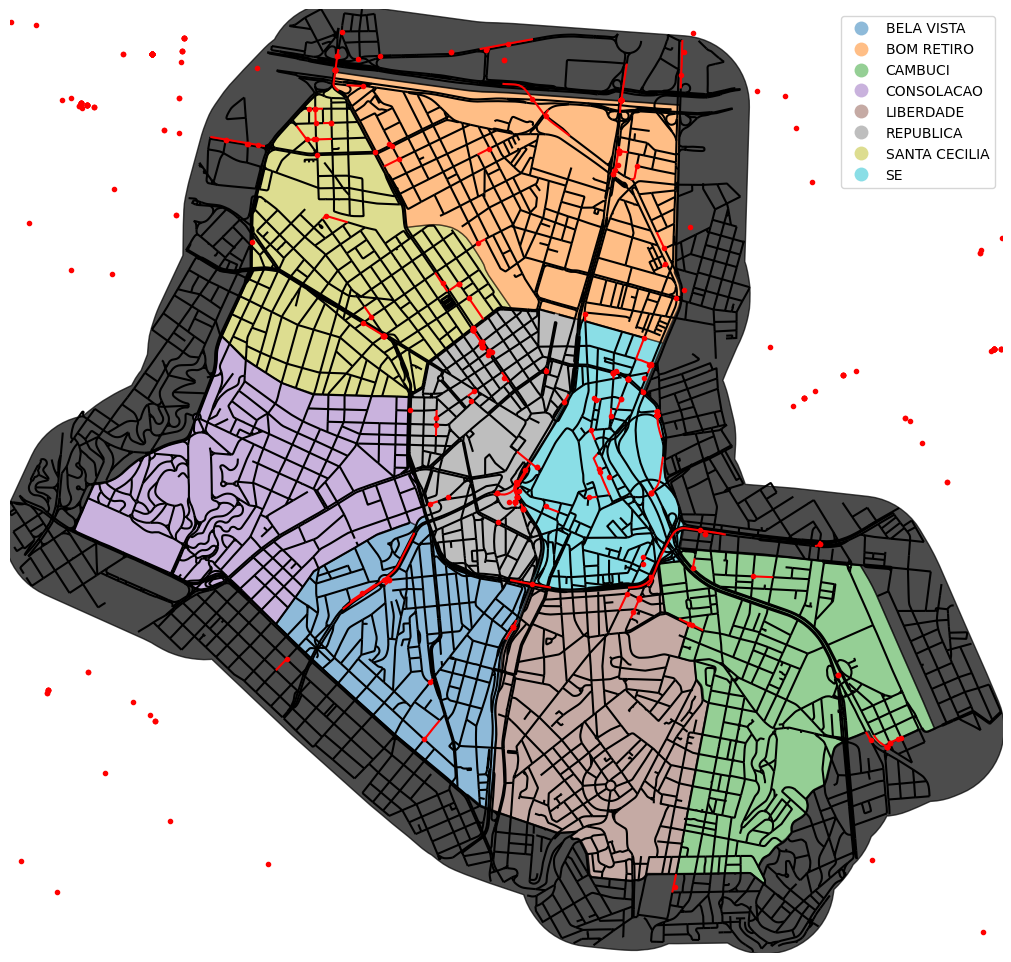

In [85]:
# Subtract the union of central polygons from each individual central district
diff_geoms = central_union.geometry.difference(unary_union(gdf_central.geometry))

# Create a GeoDataFrame for the difference
gdf_diff = gpd.GeoDataFrame(geometry=diff_geoms, crs=gdf_central.crs)
gdf_diff["NOME"] = "BUFFER"

fig, ax = plt.subplots(figsize=(10, 10), layout="constrained") # creating the figure
m = edges.sort_values(by = "flood").plot(figsize = (10,10), column = "flood", cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["k","r"]), ax = ax)
plt.plot(floods["LONG"], floods["LAT"], '.', c = "r") # plotting the floods
plt.ylim(nodes.total_bounds[1], nodes.total_bounds[3]) # limiting the space of plots
plt.xlim(nodes.total_bounds[0], nodes.total_bounds[2])
cmap = matplotlib.colormaps['jet'] # colormap for the colorbar
norm=plt.Normalize(vmin=edges['grade'].min(), vmax=edges['grade'].max()) # normalizing the values to make the colorbar
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap) # mapping
sm.set_array([])
gdf_central.plot(ax=ax, column="NOME", cmap="tab10", legend=True, edgecolor='black', alpha=0.5) # plotting the central region
gdf_diff.plot(ax=ax, column="NOME", color='black', edgecolor='black', alpha=0.7, legend = True) # plotting the difference
plt.axis('off') # removing the axis
# cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=m, orientation='horizontal', fraction=0.046, pad=0.04) # defining the colorbar
# cb.ax.tick_params(labelsize=20) # changing fontsize of the colorbar
plt.savefig("floods_center.pdf", bbox_inches='tight')